In [61]:
import numpy as np
import pandas as pd
from numpy.linalg import eigh
from scipy.stats import norm
import itertools
import statsmodels.api as sm
import math
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, models, Input

In [62]:
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(X_train.shape)
print(Y_test.shape)


(60000, 28, 28)
(10000,)


In [63]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]
Y_train = Y_train.astype("int32")


In [64]:
grid_size = 28
block_size = 14
num_blocks = grid_size // block_size  # 7

modalities = [
    [(r, c)
     for r in range(block_row * block_size, (block_row + 1) * block_size)
     for c in range(block_col * block_size, (block_col + 1) * block_size)]
    for block_row in range(num_blocks)
    for block_col in range(num_blocks)
]



In [65]:
def mask_inputs(X, coalition, modalities):
    mask = np.zeros((28, 28), dtype=np.float32)
    for j in coalition:
        for (r, c) in modalities[j]:
            mask[r, c] = 1.0

    mask = np.expand_dims(mask, axis=(0, -1))
    return X * mask

In [66]:
coalition = (0, 1, 3)
X_S_train = mask_inputs(X_train, coalition, modalities)
print(X_S_train.shape)


(60000, 28, 28, 1)


In [67]:
n = X_train.shape[0]
I1 = np.random.choice(n, n // 2, replace=False)
I2 = np.setdiff1d(np.arange(n), I1)

In [68]:
def accuracy(Y_true, Y_pred):
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    return np.mean(Y_true == Y_pred_classes)

In [69]:
def exact_shapley_linear_cached(X_train, Y_train, X_cal, Y_cal, modalities):
    p = len(modalities)
    n_cal = X_cal.shape[0]
    shapley_values = np.zeros((n_cal, p), dtype=np.float32)


    # def pixels_from_coalition(coalition):
    #     return [pixel for j in coalition for pixel in modalities[j]]

    fact = np.array([math.factorial(i) for i in range(p+1)], dtype=np.float32)

    num_classes = 10
    class_counts = np.bincount(Y_train, minlength=num_classes)
    empirical_probs = class_counts / len(Y_train)
    Y_pred_trivial = np.tile(empirical_probs, (len(Y_train), 1))

    empty_value = tf.keras.losses.sparse_categorical_crossentropy(Y_cal, Y_pred_trivial)

    ce_empty_train = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(Y_train, Y_pred_trivial))
    ce_empty_cal = tf.reduce_mean(empty_value)
    ce_empty_train = tf.cast(ce_empty_train, tf.float32)
    ce_empty_cal = tf.cast(ce_empty_cal, tf.float32)


    # cache fitted betas and predictions on cal set
    coalition_cache = {}
    utilities_cache_train = {}
    ce_cache_train = {}
    acc_cache_train = {}
    utilities_cache_cal = {}
    ce_cache_cal = {}
    acc_cache_cal = {}

    length = X_train.shape[1]

    model = models.Sequential([
                Input(shape=(length,length,1)),
                layers.Conv2D(32, (3,3), activation='relu'),
                layers.MaxPooling2D((2,2)),
                layers.Flatten(),
                layers.Dense(128, activation='relu'),
                layers.Dense(10, activation='softmax')
            ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    def get_value(S):
        if not S:
            return empty_value
        if S not in coalition_cache:
            # idx = pixels_from_coalition(S)
            # rows, cols = zip(*idx)
            # rows = np.array(rows)
            # cols = np.array(cols)
            X_S_train = mask_inputs(X_train, S, modalities)
            # length = X_S_train.shape[1]


            history = model.fit(X_S_train, Y_train,
                    epochs=5,
                    batch_size=64,
                    validation_split=0.1,
                    verbose=2)

            X_S_cal = mask_inputs(X_cal, S, modalities)
            Y_train_pred = model.predict(X_S_train, verbose=0)
            Y_cal_pred = model.predict(X_S_cal, verbose=0)

            v_S = tf.keras.losses.sparse_categorical_crossentropy(Y_cal, Y_cal_pred)
            ce_S_train = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(Y_train, Y_train_pred))
            ce_S_cal = tf.reduce_mean(v_S)

            coalition_cache[S] = v_S
            ce_S_train = tf.cast(ce_S_train, tf.float32)
            ce_S_cal = tf.cast(ce_S_cal, tf.float32)

            utilities_cache_train[S] = ce_empty_train - ce_S_train
            ce_cache_train[S] = ce_S_train
            acc_cache_train[S] = accuracy(Y_train, Y_train_pred)

            utilities_cache_cal[S] = ce_empty_cal - ce_S_cal
            ce_cache_cal[S] = ce_S_cal
            acc_cache_cal[S] = accuracy(Y_cal, Y_cal_pred)
        return coalition_cache[S].numpy().astype(np.float32)

    for i in range(p):
        others = [j for j in range(p) if j != i]
        for r in range(len(others)+1):
            for subset in itertools.combinations(others, r):
                S = tuple(sorted(subset))
                S_i = tuple(sorted(subset + (i,)))
                weight = np.float32(fact[len(S)] * fact[p - len(S) - 1] / fact[p])
                v_S = get_value(S)
                v_Si = get_value(S_i)
                shapley_values[:, i] += weight * (v_Si - v_S)

    return shapley_values, utilities_cache_train, ce_cache_train, acc_cache_train, utilities_cache_cal, ce_cache_cal, acc_cache_cal

In [70]:
shap_values_exact, util_1, ce_1, acc_1, util_2, ce_2, acc_2 = exact_shapley_linear_cached(X_train[I1,:], Y_train[I1], X_train[I2,:], Y_train[I2], modalities)

Epoch 1/5
422/422 - 14s - 33ms/step - accuracy: 0.6534 - loss: 1.0586 - val_accuracy: 0.7187 - val_loss: 0.8461
Epoch 2/5
422/422 - 13s - 30ms/step - accuracy: 0.7403 - loss: 0.7741 - val_accuracy: 0.7497 - val_loss: 0.7325
Epoch 3/5
422/422 - 13s - 30ms/step - accuracy: 0.7577 - loss: 0.7138 - val_accuracy: 0.7593 - val_loss: 0.7092
Epoch 4/5
422/422 - 21s - 49ms/step - accuracy: 0.7676 - loss: 0.6820 - val_accuracy: 0.7687 - val_loss: 0.6787
Epoch 5/5
422/422 - 13s - 32ms/step - accuracy: 0.7740 - loss: 0.6575 - val_accuracy: 0.7670 - val_loss: 0.6783
Epoch 1/5
422/422 - 13s - 31ms/step - accuracy: 0.7928 - loss: 0.6513 - val_accuracy: 0.8287 - val_loss: 0.4808
Epoch 2/5
422/422 - 13s - 30ms/step - accuracy: 0.8521 - loss: 0.4320 - val_accuracy: 0.8557 - val_loss: 0.4322
Epoch 3/5
422/422 - 13s - 30ms/step - accuracy: 0.8644 - loss: 0.3915 - val_accuracy: 0.8507 - val_loss: 0.4187
Epoch 4/5
422/422 - 21s - 49ms/step - accuracy: 0.8736 - loss: 0.3636 - val_accuracy: 0.8587 - val_loss:

In [82]:
p = len(modalities)
shap_values_sorted = np.sort(shap_values_exact, axis=0)
sig_mods = set(range(p))
alpha = .99

u1 = np.zeros(p)
c1 = np.zeros(p)
a1 = np.zeros(p)
u2 = np.zeros(p)
c2 = np.zeros(p)
a2 = np.zeros(p)


while len(sig_mods) > 0:
    S = tuple(sorted(list(sig_mods)))
    size = len(S)
    u1[size - 1] = util_1[S]
    c1[size - 1] = ce_1[S]
    a1[size - 1] = acc_1[S]
    u2[size - 1] = util_2[S]
    c2[size - 1] = ce_2[S]
    a2[size - 1] = acc_2[S]
    ell = math.ceil((n / 2 + 1) * (alpha / 2))
    u = math.ceil((n / 2 + 1) * (1 - alpha / 2))
    for j in sig_mods:
        if shap_values_sorted[ell,j] < 0 and shap_values_sorted[u,j] > 0:
            print(str(j) + ' removed')
            sig_mods.remove(j)
            print(sig_mods)
            break
    alpha = alpha - 0.01

0 removed
{1, 2, 3}
3 removed
{1, 2}
2 removed
{1}
1 removed
set()


The modalities are ordered Topleft quarter: 0, Topright quarter: 1, Bottomleft quarter: 2, Bottomright quarter: 3

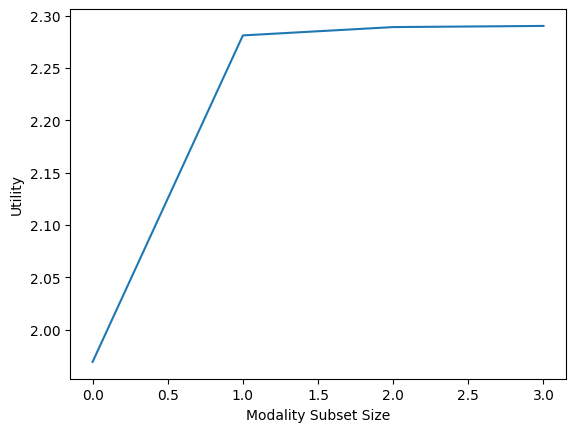

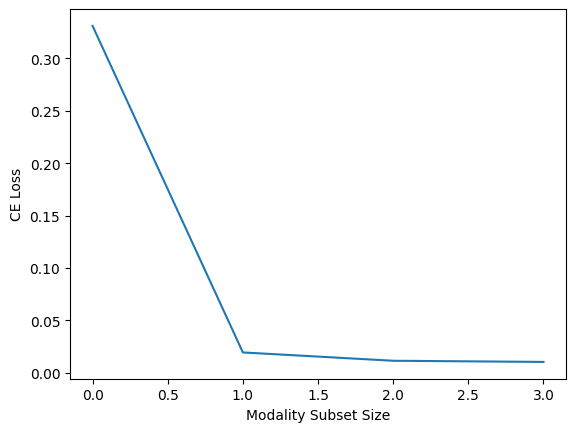

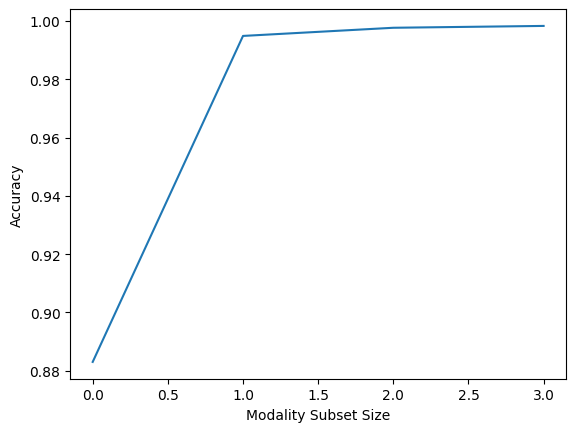

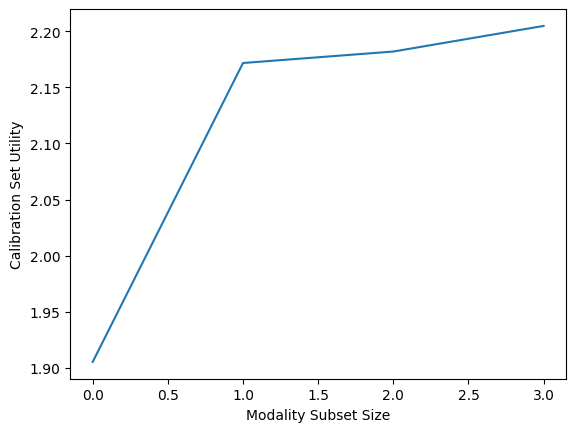

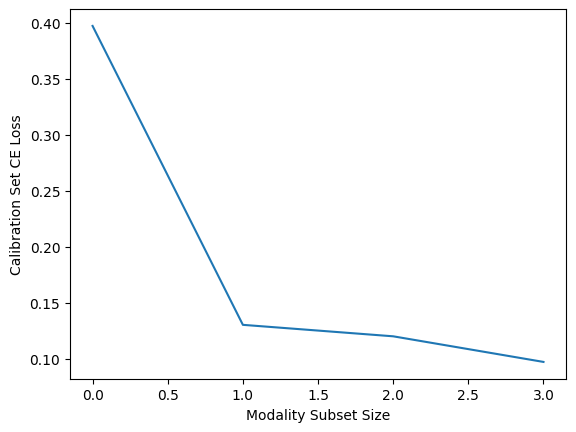

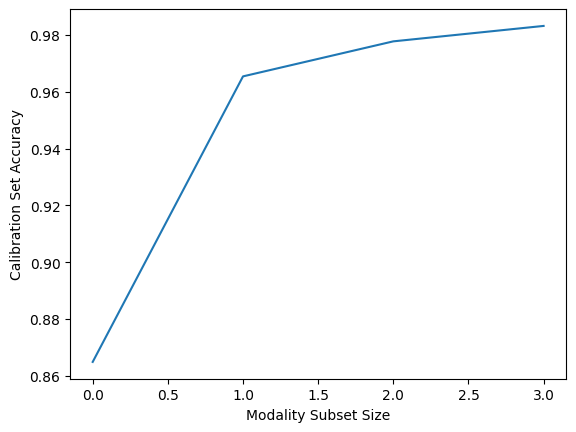

In [79]:
plt.plot(u1)
plt.xlabel("Modality Subset Size")
plt.ylabel("Utility")
plt.show()

plt.plot(c1)
plt.xlabel("Modality Subset Size")
plt.ylabel("CE Loss")
plt.show()

plt.plot(a1)
plt.xlabel("Modality Subset Size")
plt.ylabel("Accuracy")
plt.show()

plt.plot(u2)
plt.xlabel("Modality Subset Size")
plt.ylabel("Calibration Set Utility")
plt.show()

plt.plot(c2)
plt.xlabel("Modality Subset Size")
plt.ylabel("Calibration Set CE Loss")
plt.show()

plt.plot(r2)
plt.xlabel("Modality Subset Size")
plt.ylabel("Calibration Set Accuracy")
plt.show()